In [150]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from bertopic import BERTopic

In [151]:
import umap
import seaborn as sns
import numpy as np
import pandas as pd

## Lectura del dataset "app_reviews"

In [152]:
review = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
#review = pd.read_csv('C:/Users/USUARIO/Documents/Universidad/4A. Inteligencia Artificial/Dataset/app_reviews.csv')
review

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


### Se extrae en un corpus todos los reviews o criticas de usuario

In [153]:
def extract_corpus(dataset):
    lista = []  
    for i in range(len(dataset['package_name'].unique())):#iterar entre los package_name unicos
        dataset_temp = dataset.loc[dataset['package_name'] == dataset['package_name'].unique()[i]]
        lista.append({'package_name':dataset['package_name'].unique()[i], 'size': len(dataset_temp)})#otener un package_name y el número de oraciones

    lista = sorted(lista, key=lambda x: x['size'], reverse=True)#se ordena para saber que package_name tiene el mayor n° de oraciones
    dataframe = dataset[dataset['package_name'] == lista[1]['package_name']]#el mayor será el elemnto que ocupa la posicion 0
    corpus = list(dataframe['review'])#extraemos un corpus
    
    #corpus = clean_corpus(corpus)

    return corpus

### Convertir datos en un Dataframe a un manejo más ágil

In [154]:
def convert_corpus_to_dataFrame(corpus):
    corpus_ds = {
        'Sentences' : corpus
    }

    dataset_new = pd.DataFrame(corpus_ds)
    return dataset_new

In [155]:
def convert_embbedings_to_dataFrame(embeddings):
    array = []
    for i in embeddings:
        array.append([i])

    dataset_new = pd.DataFrame(array, columns=['Embeddings'])
    return dataset_new

### Se crea una función que nos permita incrustar las oraciones, para esto usamos un modelo pre-entrenado de SBERT

In [156]:
def neural_embeddings(dataset):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado
    corpus = extract_corpus(dataset)#extraemos un corpus del dataset 

    embeddings = model_embedder.encode(corpus, 
                                        convert_to_tensor=False, 
                                        show_progress_bar=True) #generamos las incrustaciones 

    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True) #normalizamos

    return embeddings, corpus

In [157]:
def neural_embeddings_queries(queries):
    model_embedder = SentenceTransformer('all-MiniLM-L6-v2')#modelo pre-entrenado

    embeddings_queries = model_embedder.encode(queries, 
                                        convert_to_tensor=False) #generamos las incrustaciones 

    embeddings_queries = embeddings_queries /  np.linalg.norm(embeddings_queries, axis=0, keepdims=True) #normalizamos

    return embeddings_queries

### Para obtener el "mejor" cluster aplicamos el método de la silueta

In [158]:
#en esta funcion hace la tarea de obtener el mejor k con agglomerative clustering
def silhoutte(dataset, attempts):

    embeddings, corpus = neural_embeddings(dataset)
    scores_silhouette = [] #guardaremos todos los resultados del método de la silueta para devolver el mayor

    for k in range(2,attempts+1):

        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, 
                                                            affinity="cosine" , 
                                                            linkage="complete").fit(embeddings)
                                                            
        cluster_labels = agglomerative_clusterering.labels_

        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        scores_silhouette.append(silhouette_avg)

    max_score = max(scores_silhouette)
    max_index = scores_silhouette.index(max_score)
    n_clusters = max_index + 2

    return n_clusters, embeddings, corpus

### Al tener el "mejor" número de clusters, se procede a segmentar las oraciones

In [159]:
def topics_segmentation(dataset_review, attempts):
    n_clusters, embeddings, corpus = silhoutte(dataset_review, attempts) # se le pasa el mejor K

    agglomerative_clusterering = AgglomerativeClustering(n_clusters=n_clusters, 
                                                        affinity="cosine", 
                                                        linkage="complete").fit(embeddings)
                                                        
    cluster_labels = agglomerative_clusterering.labels_ #obtengo las etiquetas respectivas a las oraciones

    model_topics = BERTopic(nr_topics = n_clusters).fit(corpus) # entreno para sacar K temas 
    label_topics = model_topics.generate_topic_labels() # temas
    label_topics.pop(0) #elimino el grupo de temas atípicos

    return cluster_labels, label_topics, embeddings, corpus

### A cada oración le asignamos el cluster al que pertenece

In [160]:
def clustering(dataset_review, attempts):
    cluster_labels, label_topics, embeddings, corpus = topics_segmentation(dataset_review, attempts)

    corpus_dataframe = convert_corpus_to_dataFrame(corpus) #de set de oraciones se convierte en un DF para asignarle su número de cluster
    corpus_dataframe['cluster'] = cluster_labels #se le asigna a cada oración un cluster

    return embeddings, label_topics, corpus_dataframe

### Búsqueda semántica para encontrar el tema de cada cluster

In [161]:
def semantic_search(dataset_review, attemps):
    embeddings, label_topics, corpus_dataframe = clustering(dataset_review, attemps) #tomo embeddings para no volver a hacer el mismo trabajo 2 veces
    dataframe_embeddings = convert_embbedings_to_dataFrame(embeddings) #convierto a cada lista de embeddings en un DF para evaluar con cada tema

    dataframe_embeddings['cluster'] = corpus_dataframe['cluster'] # le asigno los clusters
    sort_embeddings =  dataframe_embeddings.sort_values(by=['cluster']) 
    sort_embeddings = sort_embeddings.reset_index(drop=True)
    nr_clusters = sort_embeddings['cluster'].unique() # extrae las un representante de cada cluster

    first_sentences = [] #se almacenara cada primera oracion incrustada de cada cluster para asignarle un topic
    j = 0
    i = 0
    while i < len(sort_embeddings):               
        if(j < len(nr_clusters) and sort_embeddings['cluster'][i] == nr_clusters[j]):
            first_sentences.append(sort_embeddings['Embeddings'][i]) #almacena
            j+=1
        i+=1

    queries = label_topics #queries seran los temas
    topics = [] 
    in_clusters = [] #se almacena los temas y los clusters, para que tengan un mismo índice en comun
    for topic in queries:

        embeddings_queries = neural_embeddings_queries(topic) #incrusta los temas 
        cos_scores = util.cos_sim(embeddings_queries, first_sentences)[0] #se saca la similaridad de cada tema con respecto a las demas oraciones

        cos_scores_numpy = cos_scores.numpy() #se convierte a tensor a numpu
        cos_scores_list = cos_scores_numpy.tolist() #se convierte de numpy a list
        max_coincidence = max(cos_scores_list)
        cluster = cos_scores_list.index(max_coincidence)

        if(len(topics) == 0): 
            topics.append(topic)
            in_clusters.append(cluster)

        elif(topic not in topics and cluster not in in_clusters): #para que no repite un tema con un cluster y viceversa
            topics.append(topic)
            in_clusters.append(cluster)
    tupla = [] ##tamaño k -> k es el tamaño de cluster
    for i in range(len(topics)):
        tupla.append({'Topics': topics[i] , 'Cluster': in_clusters[i]}) #empareja    
    print(tupla)

    return embeddings, tupla, corpus_dataframe
        

### Para dar visualización de estas oraciones en un plano euclidiano, aplicamos una técnica de reducción de dimensiones 

In [162]:
def dimension_reduction(embeddings):
    scaler = umap.UMAP(n_components=2).fit_transform(embeddings)
    dimension_2d = pd.DataFrame(scaler, columns=['x', 'y'])
    return dimension_2d

### Mostraremos un gráfico de la segmentación de oraciones y un DataFrame de las oraciones con su respectivo cluster 

In [163]:
def show_graphics_and_themes(dataset_review, attemps):
    embeddings, reporte_tuplas, corpus_dataframe = semantic_search(dataset_review, attemps)
    review_2d = dimension_reduction(embeddings) #se reduce a dos dimensiones las incrustaciones para poder plotear

    review_2d['labels'] = corpus_dataframe['cluster']
    
    plt.figure(figsize=(20, 20))
    clustered = review_2d[review_2d.labels != -1]

    plt.scatter(review_2d.x, 
                review_2d.y, 
                c=clustered.labels, 
                s=20,
                cmap='Spectral')

    plt.colorbar()
    plt.show()
    
    return corpus_dataframe, reporte_tuplas

Batches: 100%|██████████| 713/713 [03:32<00:00,  3.35it/s]


[{'Topics': '0_good_apps_job', 'Cluster': 14}, {'Topics': '1_indian_india_indians', 'Cluster': 67}, {'Topics': '2_nice_one_good', 'Cluster': 30}, {'Topics': '3_very_good_telegram', 'Cluster': 72}, {'Topics': '4_super_supar_nice', 'Cluster': 71}, {'Topics': '8_fast_speed_slow', 'Cluster': 7}, {'Topics': '9_love_it_this', 'Cluster': 51}, {'Topics': '11_fantastic_amazing_lovely', 'Cluster': 26}, {'Topics': '12_ok_oky_oke', 'Cluster': 74}, {'Topics': '13_useful_very_usefull', 'Cluster': 8}, {'Topics': '14_whatsapp_than_better', 'Cluster': 62}, {'Topics': '15_tanks_tele_teligram', 'Cluster': 20}, {'Topics': '16_messaging_best_ever', 'Cluster': 61}, {'Topics': '18_perfect_replacement_spyware', 'Cluster': 49}, {'Topics': '19_nyc_gooood_gooooood', 'Cluster': 15}, {'Topics': '20_video_call_calling', 'Cluster': 44}, {'Topics': '21_files_file_photos', 'Cluster': 43}, {'Topics': '22_thanks_thank_luck', 'Cluster': 65}, {'Topics': '24_notification_notifications_open', 'Cluster': 76}, {'Topics': '25_

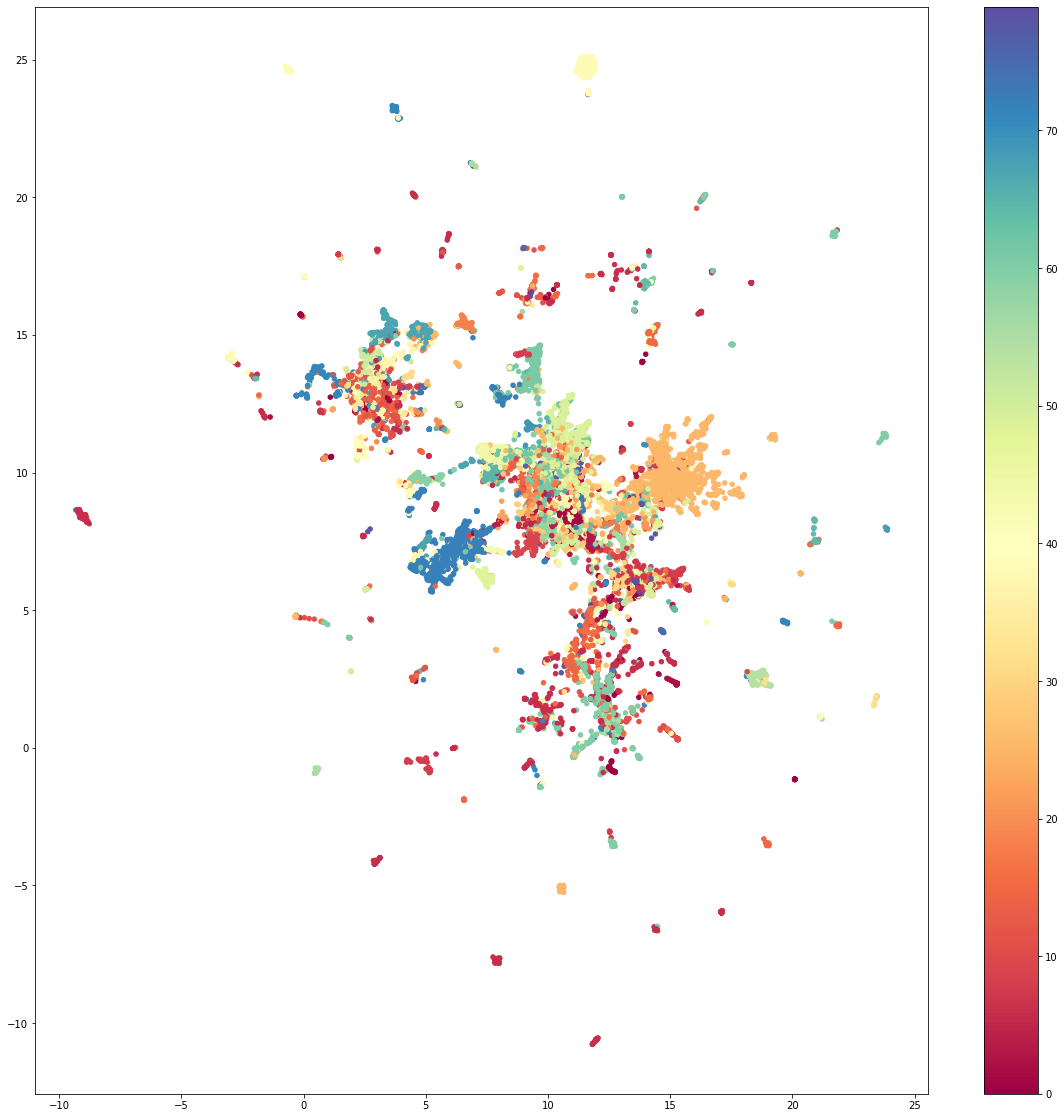

In [164]:
topics, reporte = show_graphics_and_themes(review, 80 )

In [165]:
topics

,Sentences,cluster
0,Awesome app,25
1,Nice,6
2,Rkj Fine,68
3,My Telegram I Love It,72
4,Its good application i love it.....,49
...,...,...
22811,Nice,6
22812,Gud nd nice app never seen,25
22813,I like this app,25
22814,Dunya,51


In [166]:
reporte

[{'Topics': '0_good_apps_job', 'Cluster': 14},
 {'Topics': '1_indian_india_indians', 'Cluster': 67},
 {'Topics': '2_nice_one_good', 'Cluster': 30},
 {'Topics': '3_very_good_telegram', 'Cluster': 72},
 {'Topics': '4_super_supar_nice', 'Cluster': 71},
 {'Topics': '8_fast_speed_slow', 'Cluster': 7},
 {'Topics': '9_love_it_this', 'Cluster': 51},
 {'Topics': '11_fantastic_amazing_lovely', 'Cluster': 26},
 {'Topics': '12_ok_oky_oke', 'Cluster': 74},
 {'Topics': '13_useful_very_usefull', 'Cluster': 8},
 {'Topics': '14_whatsapp_than_better', 'Cluster': 62},
 {'Topics': '15_tanks_tele_teligram', 'Cluster': 20},
 {'Topics': '16_messaging_best_ever', 'Cluster': 61},
 {'Topics': '18_perfect_replacement_spyware', 'Cluster': 49},
 {'Topics': '19_nyc_gooood_gooooood', 'Cluster': 15},
 {'Topics': '20_video_call_calling', 'Cluster': 44},
 {'Topics': '21_files_file_photos', 'Cluster': 43},
 {'Topics': '22_thanks_thank_luck', 'Cluster': 65},
 {'Topics': '24_notification_notifications_open', 'Cluster': 76

In [167]:
reporte_tuplas_ = pd.DataFrame(reporte, columns=['Topics','Cluster'])
reporte_tuplas_

,Topics,Cluster
0,0_good_apps_job,14
1,1_indian_india_indians,67
2,2_nice_one_good,30
3,3_very_good_telegram,72
4,4_super_supar_nice,71
5,8_fast_speed_slow,7
6,9_love_it_this,51
7,11_fantastic_amazing_lovely,26
8,12_ok_oky_oke,74
9,13_useful_very_usefull,8
